#Install Dependencies

In [1]:
!pip install sentence_transformers
!pip install pyterrier
!pip install Arabic-Stopwords
!pip install pytrec_eval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.4 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=8c321ad93f3d0ca0263de7e8cfb5284656ef6705f7ba8988540413ea24bcbc37
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.5/360.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytrec_eval: filename=pytrec_eval-0.5-cp310-cp310-linux_x86_64.whl size=308215 sha256=a936103086e753713772dd845631693b4d7aed2fa010387b99488da7549d1636
  Stored in directory: /root/.cache/pip/wheels/51/3a/cd/dcc1ddfc763987d5cb237165d8ac249aa98a23ab

In [2]:
import numpy as np
import pandas as pd
import re
import pandas as pd
from snowballstemmer import stemmer
import arabicstopwords.arabicstopwords as ar_stp
import pyterrier as pt

import json
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets,  CrossEncoder, util
from transformers import AutoTokenizer
import gzip
import os
import torch

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")

from sklearn.feature_extraction import _stop_words
import string
from tqdm.autonotebook import tqdm

from torch import nn
import os
import time


#Load the data
##Training set for training the model

In [3]:
!git clone https://gitlab.com/bigirqu/quranqa.git

Cloning into 'quranqa'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 333 (delta 43), reused 86 (delta 43), pack-reused 247
Receiving objects: 100% (333/333), 312.88 KiB | 558.00 KiB/s, done.
Resolving deltas: 100% (130/130), done.


In [4]:
!git clone https://gitlab.com/bigirqu/quran-qa-2023.git

Cloning into 'quran-qa-2023'...
remote: Enumerating objects: 1018, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 1018 (delta 32), reused 0 (delta 0), pack-reused 963
Receiving objects: 100% (1018/1018), 1.14 MiB | 2.89 MiB/s, done.
Resolving deltas: 100% (479/479), done.


In [5]:
df = pd.read_csv("/content/train_data.csv")
df.head()

Question  \
0  اتفاقية ""سيداو"" تقول الرجل لا يملك الولاية ع...   
1  اتفاقية ""سيداو"" تقول الرجل لا يملك الولاية ع...   
2  اتفاقية ""سيداو"" تقول الرجل لا يملك الولاية ع...   
3  اتفاقية ""سيداو"" تقول الرجل لا يملك الولاية ع...   
4  اتفاقية ""سيداو"" تقول الرجل لا يملك الولاية ع...   

                                             Passage  
0  الرجال قوامون على النساء بما فضل الله بعضهم عل...  
1  والذين يتوفون منكم ويذرون أزواجا يتربصن بأنفسه...  
2  والمطلقات يتربصن بأنفسهن ثلاثة قروء ولا يحل له...  
3  يا أيها الذين آمنوا قوا أنفسكم وأهليكم نارا وق...  
4  يا أيها النبي قل لأزواجك وبناتك ونساء المؤمنين...

In [6]:
df2 = pd.read_csv("/content/Quran_2022.csv")
df2.head()

pq_id                                            passage  \
0  10:107-109_372  وإن يمسسك الله بضر فلا كاشف له إلا هو وإن يردك...   
1  10:107-109_372  وإن يمسسك الله بضر فلا كاشف له إلا هو وإن يردك...   
2  10:107-109_417  وإن يمسسك الله بضر فلا كاشف له إلا هو وإن يردك...   
3    10:15-17_372  وإذا تتلى عليهم آياتنا بينات قال الذين لا يرجو...   
4    10:15-17_372  وإذا تتلى عليهم آياتنا بينات قال الذين لا يرجو...   

                                            question  surah   verses  answers  \
0  ما الدلائل على أن القرآن ليس من تأليف سيدنا مح...     10  107-109      NaN   
1  ما الدلائل على أن القرآن ليس من تأليف سيدنا مح...     10  107-109      NaN   
2  هل سمح الإسلام بحرية الاعتقاد بالدخول إلى الإس...     10  107-109      NaN   
3  ما الدلائل على أن القرآن ليس من تأليف سيدنا مح...     10    15-17      NaN   
4  ما الدلائل على أن القرآن ليس من تأليف سيدنا مح...     10    15-17      NaN   

                                        answers.text  answers.start_char  
0                                                NaN                 NaN  
1                                  اتبع ما يوحى إليك               222.0  
2  يا أيها الناس قد جاءكم الحق من ربكم فمن اهتدى ...               113.0  
3                                                NaN                 NaN  
4                        إذا تتلى عليهم آياتنا بينات                 1.0

In [7]:
df.describe()

Question  \
count                                                1522   
unique                                                213   
top     ما الدلائل على أن القرآن ليس من تأليف سيدنا مح...   
freq                                                  144   

                                                  Passage  
count                                                1522  
unique                                                780  
top     الذين كفروا وصدوا عن سبيل الله أضل أعمالهم. وا...  
freq                                                    8

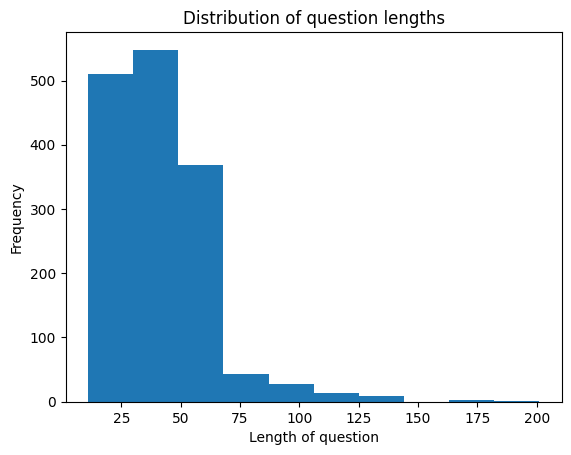

In [8]:
import matplotlib.pyplot as plt
plt.hist(df.Question.str.len())
plt.xlabel("Length of question")
plt.ylabel("Frequency")
plt.title("Distribution of question lengths")
plt.show()

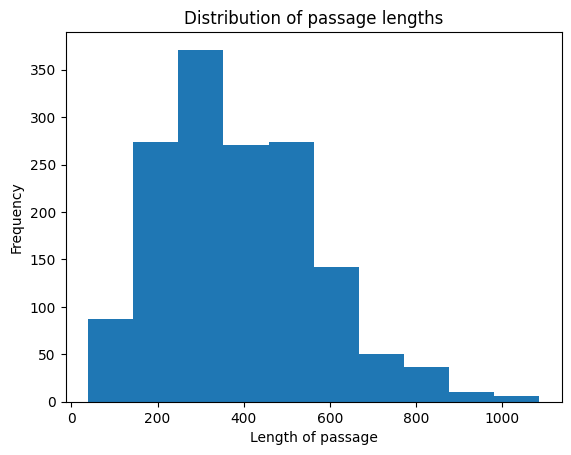

In [9]:
plt.hist(df.Passage.str.len())
plt.xlabel("Length of passage")
plt.ylabel("Frequency")
plt.title("Distribution of passage lengths")
plt.show()

In [10]:
train_examples = []
for n in np.arange(0, len(df)):
  train_examples.append(InputExample(texts=[str(df['Question'][n]), str(df['Passage'][n])]))

for n in np.arange(0, len(df2)):
  train_examples.append(InputExample(texts=[str(df2['question'][n]), str(df2['answers'][n])]))

# For the MultipleNegativesRankingLoss, we use NoDuplicatesDataLoader to make sure no duplicated records
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=16)

In [11]:
len(train_examples)

3085

#Test set


In [12]:
df_validation = pd.read_csv("/content/quran-qa-2023/Task-A/data/QQA23_TaskA_ayatec_v1.2_test.tsv", sep = '\t', names = ['ID_Question', 'Question'])
df_validation.head()

ID_Question                                           Question
0          500      من ماذا نجى الله سبحانه وتعالى سيدنا إبراهيم؟
1          502  ما الدلائل على أن الانبياء والرسل لا يعلمون ال...
2          504            أين يقع الكهف الذي أوى إليه فتية الكهف؟
3          505  ما الدلائل على أن القرآن أُنزل لجميع الناس أو ...
4          508  مع ازدياد عدد سكان الارض، هل يجب أن نقلق أو نخ...

In [28]:
questions_list = df_validation['ID_Question'].tolist()

#QPC data to encoded by model

In [13]:
df_val = pd.read_csv("/content/quran-qa-2023/Task-A/data/Thematic_QPC/QQA23_TaskA_QPC_v1.1.tsv", sep='\t', names=['ID', 'Passage'])
df_val.head()

ID                                            Passage
0  1:1-4  بسم الله الرحمن الرحيم. الحمد لله رب العالمين....
1  1:5-6     إياك نعبد وإياك نستعين. اهدنا الصراط المستقيم.
2  1:7-7  صراط الذين أنعمت عليهم غير المغضوب عليهم ولا ا...
3  2:1-2            الم. ذلك الكتاب لا ريب فيه هدى للمتقين.
4  2:3-5  الذين يؤمنون بالغيب ويقيمون الصلاة ومما رزقناه...

In [14]:
passages_val = []
for n in df_val['Passage']:
  print(n)
  passages_val.append(str(n))

print(len(passages_val))

بسم الله الرحمن الرحيم. الحمد لله رب العالمين. الرحمن الرحيم. مالك يوم الدين.
إياك نعبد وإياك نستعين. اهدنا الصراط المستقيم.
صراط الذين أنعمت عليهم غير المغضوب عليهم ولا الضالين.
الم. ذلك الكتاب لا ريب فيه هدى للمتقين.
الذين يؤمنون بالغيب ويقيمون الصلاة ومما رزقناهم ينفقون. والذين يؤمنون بما أنزل إليك وما أنزل من قبلك وبالآخرة هم يوقنون. أولئك على هدى من ربهم وأولئك هم المفلحون.
إن الذين كفروا سواء عليهم أأنذرتهم أم لم تنذرهم لا يؤمنون. ختم الله على قلوبهم وعلى سمعهم وعلى أبصارهم غشاوة ولهم عذاب عظيم.
ومن الناس من يقول آمنا بالله وباليوم الآخر وما هم بمؤمنين. يخادعون الله والذين آمنوا وما يخدعون إلا أنفسهم وما يشعرون. في قلوبهم مرض فزادهم الله مرضا ولهم عذاب أليم بما كانوا يكذبون. وإذا قيل لهم لا تفسدوا في الأرض قالوا إنما نحن مصلحون. ألا إنهم هم المفسدون ولكن لا يشعرون. وإذا قيل لهم آمنوا كما آمن الناس قالوا أنؤمن كما آمن السفهاء ألا إنهم هم السفهاء ولكن لا يعلمون. وإذا لقوا الذين آمنوا قالوا آمنا وإذا خلوا إلى شياطينهم قالوا إنا معكم إنما نحن مستهزئون. الله يستهزئ بهم ويمدهم في طغيان

# Train model


In [15]:
bi_encoder = SentenceTransformer('asafaya/bert-base-arabic')
bi_encoder.max_seq_length = 512
top_k = 32

# We use a cross-encoder, to re-rank the bi-encoder's results list to improve the quality
cross_encoder = CrossEncoder('nreimers/mmarco-mMiniLMv2-L12-H384-v1')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/445 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.68k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/813 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

# Set up the model

In [16]:
word_emb = models.Transformer('asafaya/bert-base-arabic', max_seq_length=512)
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])

# Train loss
train_loss = losses.MultipleNegativesRankingLoss(model)

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/334k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [17]:
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/192 [00:00<?, ?it/s]

Iteration:   0%|          | 0/192 [00:00<?, ?it/s]

Iteration:   0%|          | 0/192 [00:00<?, ?it/s]

Iteration:   0%|          | 0/192 [00:00<?, ?it/s]

Iteration:   0%|          | 0/192 [00:00<?, ?it/s]

In [18]:
model.save('ArabicBERT')

#Retrieve Relevant Passages

In [19]:
model = SentenceTransformer('ArabicBERT')

In [20]:
corpus_embeddings = model.encode(passages_val, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

#Preprocessing

In [21]:
ar_stemmer = stemmer("arabic")


# normalize the arabic text
def normalize_arabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    # text = re.sub("ة", "ه", text)
    return(text)

def deNoise(text):
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    return text

def arabic_preprocessing(text):
  text = normalize_arabic(text)
  text = deNoise(text)
  return text


In [22]:
x = df_validation['Question'][0]
print(x)
arabic_preprocessing(x)

من ماذا نجى الله سبحانه وتعالى سيدنا إبراهيم؟


'من ماذا نجي الله سبحانه وتعالي سيدنا ابراهيم؟'

#Retrieve the semantically relevant answers using bi-encoders

In [30]:
def search(num):

    questions = []

    answers_bi = []
    score_bi = []
    passage_bi = []
    rank_bi = []
    count_bi = 1


    ##### get the question from index
    query = df_validation.loc[df_validation['ID_Question'] == num, 'Question'].iloc[0]
    query = arabic_preprocessing(query)
    print("Input question:", query)

    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = model.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    # Get the top 20 answers
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    for hit in hits[0:20]:
      questions.append(query)
      answers_bi.append(passages_val[hit['corpus_id']])
      score_bi.append(hit['score'])
      rank_bi.append(count_bi)
      count_bi += 1
      if passages_val[hit['corpus_id']] == 'nan':
        passage_bi.append('-1')
      else:
        passage_id_val = df_val.loc[df_val['Passage'] == passages_val[hit['corpus_id']], 'ID'].iloc[0]
        passage_bi.append(passage_id_val)


    ##### Save it to a dafataframe #####
    df_answers = pd.DataFrame({
        'Question': questions,
        'answers_bi': answers_bi,
        'rank_bi': rank_bi,
        'score_bi': score_bi,
        'passage_bi': passage_bi
    })

    df_answers['Q0'] = 'Q0'
    df_answers['q_id'] = num

    return df_answers

In [31]:
testing_results = search(613)
testing_results

Input question: كيف نوفق بين الخوف من الله والرجاء فيه؟


Question  \
0   كيف نوفق بين الخوف من الله والرجاء فيه؟   
1   كيف نوفق بين الخوف من الله والرجاء فيه؟   
2   كيف نوفق بين الخوف من الله والرجاء فيه؟   
3   كيف نوفق بين الخوف من الله والرجاء فيه؟   
4   كيف نوفق بين الخوف من الله والرجاء فيه؟   
5   كيف نوفق بين الخوف من الله والرجاء فيه؟   
6   كيف نوفق بين الخوف من الله والرجاء فيه؟   
7   كيف نوفق بين الخوف من الله والرجاء فيه؟   
8   كيف نوفق بين الخوف من الله والرجاء فيه؟   
9   كيف نوفق بين الخوف من الله والرجاء فيه؟   
10  كيف نوفق بين الخوف من الله والرجاء فيه؟   
11  كيف نوفق بين الخوف من الله والرجاء فيه؟   
12  كيف نوفق بين الخوف من الله والرجاء فيه؟   
13  كيف نوفق بين الخوف من الله والرجاء فيه؟   
14  كيف نوفق بين الخوف من الله والرجاء فيه؟   
15  كيف نوفق بين الخوف من الله والرجاء فيه؟   
16  كيف نوفق بين الخوف من الله والرجاء فيه؟   
17  كيف نوفق بين الخوف من الله والرجاء فيه؟   
18  كيف نوفق بين الخوف من الله والرجاء فيه؟   
19  كيف نوفق بين الخوف من الله والرجاء فيه؟   

                                           answers_bi  rank_bi  score_bi  \
0   أولئك الذين يدعون يبتغون إلى ربهم الوسيلة أيهم...        1  0.598185   
1   إن الذين كفروا من أهل الكتاب والمشركين في نار ...        2  0.595976   
2     إن الذين يخشون ربهم بالغيب لهم مغفرة وأجر كبير.        3  0.579132   
3   ألم تر أن الله أنزل من السماء ماء فأخرجنا به ث...        4  0.567312   
4   أحل لكم صيد البحر وطعامه متاعا لكم وللسيارة وح...        5  0.535306   
5   وإن تعجب فعجب قولهم أإذا كنا ترابا أإنا لفي خل...        6  0.531723   
6   يسألونك عن الأنفال قل الأنفال لله والرسول فاتق...        7  0.530539   
7   للذين استجابوا لربهم الحسنى والذين لم يستجيبوا...        8  0.528603   
8   إن الذين قالوا ربنا الله ثم استقاموا تتنزل علي...        9  0.520408   
9   حم. تنزيل الكتاب من الله العزيز العليم. غافر ا...       10  0.489850   
10  الذين آمنوا وتطمئن قلوبهم بذكر الله ألا بذكر ا...       11  0.475560   
11  ألم تر أن الله أنزل من السماء ماء فسلكه ينابيع...       12  0.471021   
12  هو الذي يريكم البرق خوفا وطمعا وينشئ السحاب ال...       13  0.470699   
13  وزكريا إذ نادى ربه رب لا تذرني فردا وأنت خير ا...       14  0.470464   
14  وما كان لمؤمن ولا مؤمنة إذا قضى الله ورسوله أم...       15  0.465892   
15  إن الذين سبقت لهم منا الحسنى أولئك عنها مبعدون...       16  0.458256   
16  إنما يؤمن بآياتنا الذين إذا ذكروا بها خروا سجد...       17  0.456285   
17  وممن حولكم من الأعراب منافقون ومن أهل المدينة ...       18  0.455195   
18  لا يتخذ المؤمنون الكافرين أولياء من دون المؤمن...       19  0.453702   
19  ونفخ في الصور ذلك يوم الوعيد. وجاءت كل نفس معه...       20  0.453468   

    passage_bi  Q0  q_id  
0     17:57-58  Q0   613  
1       98:6-8  Q0   613  
2     67:12-12  Q0   613  
3     35:27-28  Q0   613  
4     5:96-100  Q0   613  
5       13:5-7  Q0   613  
6        8:1-4  Q0   613  
7     13:18-24  Q0   613  
8     41:30-32  Q0   613  
9       40:1-4  Q0   613  
10    13:28-29  Q0   613  
11    39:21-26  Q0   613  
12    13:12-13  Q0   613  
13    21:89-90  Q0   613  
14    33:36-40  Q0   613  
15  21:101-103  Q0   613  
16    32:15-17  Q0   613  
17   9:101-106  Q0   613  
18     3:28-30  Q0   613  
19    50:20-35  Q0   613

In [35]:
for q in questions_list:
  if q == 500:
    print(q)
    df_results = search(q)
    df_results_merge = pd.concat([df_results])
    continue
  else:
    print(q)
    df_results_again = search(q)
    df_results_merge = pd.concat([df_results_merge, df_results_again])

500
Input question: من ماذا نجي الله سبحانه وتعالي سيدنا ابراهيم؟
502
Input question: ما الدلاءل علي ان الانبياء والرسل لا يعلمون الغيب؟
504
Input question: اين يقع الكهف الذي اوي اليه فتية الكهف؟
505
Input question: ما الدلاءل علي ان القران انزل لجميع الناس او جميع الامم والشعوب؟
508
Input question: مع ازدياد عدد سكان الارض، هل يجب ان نقلق او نخاف من عدم كفاية مصادر الغذاء والرزق؟
510
Input question: اتفاقية ""سيداو"" تقول لا يسمح للرجل بتعدد الزوجات. كيف نرد علي ذلك من نصوص القران؟
513
Input question: اتفاقية ""سيداو"" تقول الرجل لا يملك الولاية علي المراة والاب لا يملك الولاية علي بناته.  كيف نرد علي ذلك من نصوص القران؟
518
Input question: لكون البخل لا يقتصر علي المال فقط، ماذا يشمل البخل او الشح (بما فيه المال)؟
519
Input question: ما هي عواقب البخل او الشح؟
521
Input question: من المشككين من يتساءل: هل عوقب جميع البشر علي ذنب اقترفه سيدنا ادم؟
522
Input question: ما الفرق بين التبذير والاسراف؟
525
Input question: ماذا تشمل الامانة في القران؟
527
Input question: لماذا قد يبتلي الل

In [36]:
df_results_merge.reset_index(inplace=True)

In [37]:
df_results_bi = df_results_merge[['q_id', 'Q0', 'passage_bi', 'rank_bi', 'score_bi']]

In [38]:
df_results_bi['run'] = 'ArabicBERT_run'
df_results_bi

<ipython-input-38-ce6c1e6b034c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results_bi['run'] = 'ArabicBERT_run'


q_id  Q0  passage_bi  rank_bi  score_bi             run
0      500  Q0    37:83-98        1  0.700041  ArabicBERT_run
1      500  Q0    21:51-68        2  0.640343  ArabicBERT_run
2      500  Q0    21:69-73        3  0.609819  ArabicBERT_run
3      500  Q0    19:41-50        4  0.600526  ArabicBERT_run
4      500  Q0    29:24-27        5  0.585339  ArabicBERT_run
...    ...  ..         ...      ...       ...             ...
1035   613  Q0  21:101-103       16  0.458256  ArabicBERT_run
1036   613  Q0    32:15-17       17  0.456285  ArabicBERT_run
1037   613  Q0   9:101-106       18  0.455195  ArabicBERT_run
1038   613  Q0     3:28-30       19  0.453702  ArabicBERT_run
1039   613  Q0    50:20-35       20  0.453468  ArabicBERT_run

[1040 rows x 6 columns]

In [39]:
df_results_bi.to_csv("ArabicBERT_run.csv", index=False, header=False)

In [40]:
df_results_bi.to_csv("ArabicBERT_run.tsv", sep='\t', index=False, header=False)